In [1]:
import numpy as np
import torch

from eot_benchmark.gaussian_mixture_benchmark import ConditionalPlan
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from auxiliary_2d_data import GaussianSampler, MoonsSampler, plot_two_distirubtions, plot_mapping, plot_2d_benchmark

## Gaussian -> Moons

### Config

In [2]:
N_CLUSTERS = 100
EPS = 0.05
SIGMA = 0.001 # \lambda = EPS / SIGMA due to different parametrization in code
DIM = 2

### Benchmark construction

In [3]:
X_sampler = GaussianSampler()
Y_sampler = MoonsSampler()

Y_train = torch.cat([Y_sampler.sample(1000) for i in range(10)], dim=0).cpu().numpy()

k_means = KMeans(n_clusters=N_CLUSTERS)
k_means.fit(Y_train)

potential_probs = torch.ones(N_CLUSTERS)/N_CLUSTERS
potential_mus = torch.tensor(k_means.cluster_centers_).float()
potential_sigmas = torch.diag(torch.tensor([SIGMA]*DIM))[None, :].repeat(N_CLUSTERS, 1, 1)

conditional_plan = ConditionalPlan(potential_probs, potential_mus, potential_sigmas, eps=EPS, device="cuda")

### Results visualization

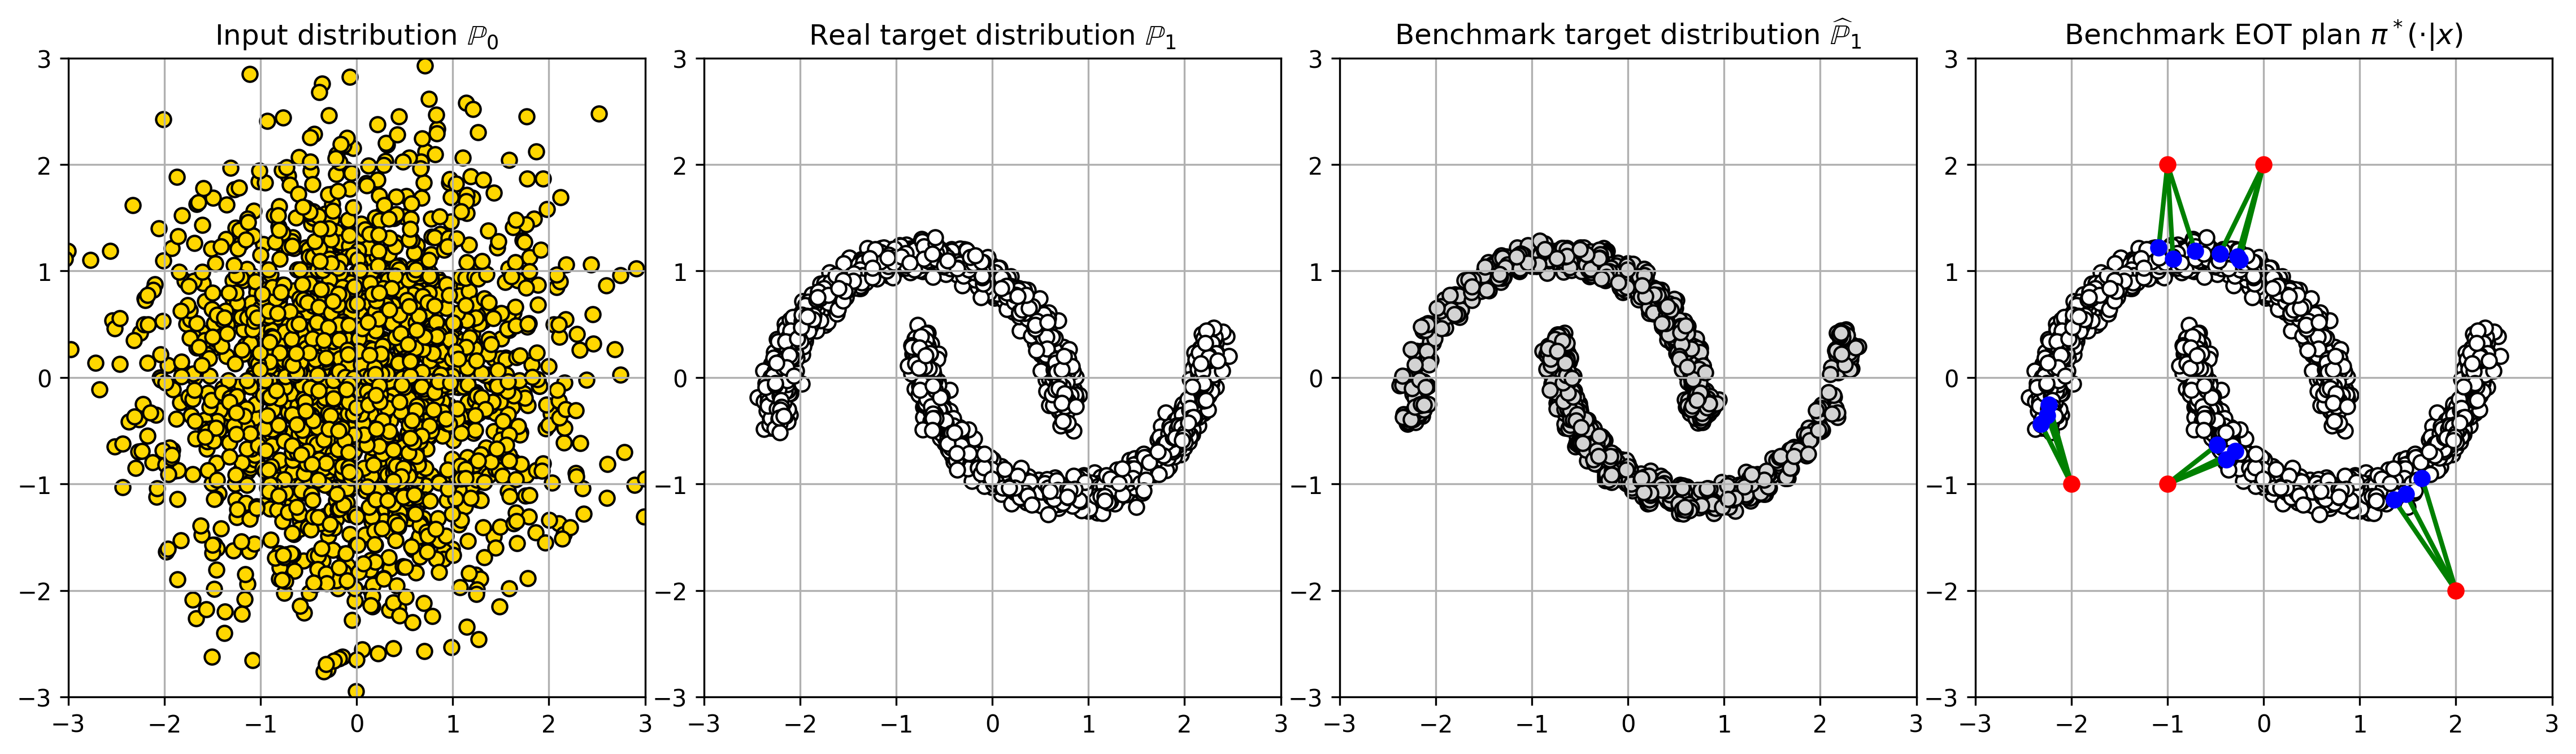

In [4]:
input_samples = X_sampler.sample(2000).detach().cpu().numpy()
benchmark_target = conditional_plan.sample(X_sampler.sample(2000)).detach().cpu().numpy()
target_samples = Y_sampler.sample(2000).detach().cpu().numpy()

# mapping
n_x, n_samples = 5, 3
X_samples = torch.tensor([[-1, 2], [0, 2], [-1, -1], [-2, -1], [2, -2]]).cuda().float()
X_repeated = X_samples[:n_x][:, None, :].repeat(1, n_samples, 1)
pred = conditional_plan.sample(X_repeated.reshape(n_x*n_samples, -1)).reshape(n_x, n_samples, -1)
mapping = torch.cat((X_repeated, pred), dim=2).detach().cpu().numpy()

#plot
plot_2d_benchmark(input_samples, target_samples, benchmark_target, mapping, save_img_name="Gaussian_Moon.png")